<a href="https://colab.research.google.com/github/katarinagresova/XAI_MALTAomics23/blob/dev/interpreting_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting Neural Networks for Computer Vision

In this notebook, we will look at several examples how to look under the hood of neural networks working with image data.

We will work with already trained model downloaded from TensorFlow, therefore all code connected with the neural network will be written in python and TensorFlow framework.

We will use several interpretation techniques to examine the model and its prediction. We will not go into the theoretical background of interpretation methods, but links to more detailed explanations will be provided.

![](https://www.medoid.ai/wp-content/uploads/2022/06/IML-2-1024x576.png) (source: https://www.medoid.ai/)

# 1. Setup



## 1.1. Imports

In [1]:
import tensorflow as tf
import keras

import requests
from PIL import Image
from io import BytesIO

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.cm as cm

## 1.2. Input data

There are several images prepared in the `images_for_test_map`. You can use them by selecting one of the options from the following selection:

`['tiger', 'bus', 'car', 'cat', 'dog', 'cat_and_dog', 'african_elephant', 'apple', 'banana', 'turtle', 'flamingo', 'piano', 'honeycomb', 'teapot', 'fireboat']`

In [2]:
images_for_test_map = {
    "tiger": "https://upload.wikimedia.org/wikipedia/commons/b/b0/Bengal_tiger_%28Panthera_tigris_tigris%29_female_3_crop.jpg",
    "bus": "https://upload.wikimedia.org/wikipedia/commons/6/63/LT_471_%28LTZ_1471%29_Arriva_London_New_Routemaster_%2819522859218%29.jpg",
    "car": "https://upload.wikimedia.org/wikipedia/commons/4/49/2013-2016_Toyota_Corolla_%28ZRE172R%29_SX_sedan_%282018-09-17%29_01.jpg",
    "cat": "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg",
    "bobcat": "https://news.ok.ubc.ca/wp-content/uploads/2019/01/Bobcat-770.jpg",
    "cat_ceiling": "https://bloximages.chicago2.vip.townnews.com/thestar.com/content/tncms/assets/v3/editorial/8/5e/85ebde4e-1658-5bd6-8661-27e4e9af8e85/63ea2da48af39.image.jpg?resize=400%2C300",
    "dog": "https://upload.wikimedia.org/wikipedia/commons/archive/a/a9/20090914031557%21Saluki_dog_breed.jpg",
    "cat_and_dog": "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
    "african_elephant": "https://i.imgur.com/Bvro0YD.png",
    "apple": "https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg",
    "banana": "https://upload.wikimedia.org/wikipedia/commons/1/1c/Bananas_white_background.jpg",
    "turtle": "https://upload.wikimedia.org/wikipedia/commons/8/80/Turtle_golfina_escobilla_oaxaca_mexico_claudio_giovenzana_2010.jpg",
    "flamingo": "https://upload.wikimedia.org/wikipedia/commons/b/b8/James_Flamingos_MC.jpg",
    "piano": "https://upload.wikimedia.org/wikipedia/commons/d/da/Steinway_%26_Sons_upright_piano%2C_model_K-132%2C_manufactured_at_Steinway%27s_factory_in_Hamburg%2C_Germany.png",
    "honeycomb": "https://upload.wikimedia.org/wikipedia/commons/f/f7/Honey_comb.jpg",
    "teapot": "https://upload.wikimedia.org/wikipedia/commons/4/44/Black_tea_pot_cropped.jpg",
    "fireboat": "https://upload.wikimedia.org/wikipedia/commons/0/06/A_Portland_fireboat_-a.jpg"
}

For the image loading, we will use this `load_image()` helper function. It does some necessary steps like downloading the image and converting it into an array of numbers of required shape.

In [3]:
def load_image(image_name, size):

    # Downloading the image from the url
    img_path = keras.utils.get_file(
      image_name + ".jpg", images_for_test_map[image_name]
    )
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    # `img_array` is preprocessed input for Xception neural net
    img_array = keras.applications.xception.preprocess_input(array)

    return img_array, img

We need to specify the image size to reshape the image into the shape required by the neural network model. Usualy, neural networks expect input with the fixed size. As we will see below, we will work with an Xception model that expect input images of size 299 by 299 pixels.

In [4]:
# input size expected by a Xception model
img_size = (299, 299)

# `img_array` is for the input of neural network and `img` is for displaing
img_array, img = load_image(image_name="fireboat", size=img_size)

1927871/1927871 [==============================] - 0s 0us/step


For the computer (and neural network in this case) the image is just an array of numbers. Dimensions of our image array are `(1, 299, 299, 3)`, where `1` is the number of images in the batch, `(299, 299)` is the width and height of an image and `3` is the depth of RGB image (3 channels for red, green and blue).

In [5]:
img_array.shape

(1, 299, 299, 3)

When we print an image array, we see that it really is just an array of numbers. Values are in the range `<-1, 1>` becase neural networks usualy work nicely with inputs in this range and the neural network we will use here was trained on input in this range.

In [6]:
img_array

array([[[[ 0.05098045,  0.1686275 ,  0.12941182],
         [ 0.10588241,  0.22352946,  0.18431377],
         [ 0.10588241,  0.20784318,  0.15294123],
         ...,
         [-0.05882353,  0.06666672,  0.27058828],
         [-0.19999999,  0.03529418,  0.23921573],
         [-0.17647058,  0.07450986,  0.254902  ]],

        [[ 0.09019613,  0.18431377,  0.10588241],
         [ 0.19215691,  0.32549024,  0.24705887],
         [ 0.18431377,  0.27058828,  0.22352946],
         ...,
         [-0.04313725,  0.13725495,  0.3803922 ],
         [-0.05882353,  0.09019613,  0.3411765 ],
         [-0.10588235,  0.09803927,  0.35686278]],

        [[ 0.03529418,  0.18431377,  0.13725495],
         [ 0.01176476,  0.20784318,  0.16078436],
         [ 0.18431377,  0.27843142,  0.26274514],
         ...,
         [-0.04313725,  0.11372554,  0.38823533],
         [-0.08235294,  0.14509809,  0.41176474],
         [-0.02745098,  0.09019613,  0.33333337]],

        ...,

        [[-0.52156866, -0.372549  , -0

It can be hard to see connection between this array of numbers and an RGB image. But we can better visualize it on the grayscale image. Here, we just encode each pixel by a value of color between 0 and 1.

![](https://i.stack.imgur.com/gC1x7.png)

And for us as humans, we can just plot the image. `img` is a PIL image and can by plotted just as it is.

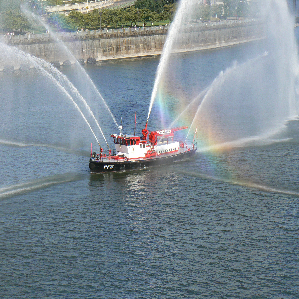

In [7]:
img

### Exercise 1: Add custom image

In the **Definitions** sections, there is variable `images_for_test_map` with pairs **image name** and **image url**. You can find your own image and add it to the `images_for_test_map`.

In [8]:
# TODO: load your custom image

## 1.3. Model

In this notebook, we will work with the [Xception](https://keras.io/api/applications/xception/) neural network. It is a neural network based on the convolutions and trained on the [ImageNet](https://www.image-net.org/) dataset (collection of labeled images).

We can use Keras interface to load trained model. There are several useful default parameters:

```python
keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
```
and the only thing we need to specify is the `input_shape`. We will use images `299x299` pixels and the depth is `3` since we are working with the RGB images. We already used these dimensions when loading our image.

We keep default parameter `include_top=True`. This will put a dense layers after the convolutional layers and our model will be classification model - it will output its predictions about object present in the input image.

In [9]:
model = keras.applications.xception.Xception(
    input_shape=(img_size[0], img_size[1], 3)
)

91884032/91884032 [==============================] - 1s 0us/step


To get the prediction from the model, we need to call the model object with the input data encoded as an array.

In [10]:
preds = model(img_array).numpy()

Xception model was trained to classify images into `1000` categories. Predictions returned from the model are therefore in the form of array of `1000` probabilities. The first dimension is 1 because we passed 1 image as an input.

In [11]:
preds.shape

(1, 1000)

Each one of the 1000 numbers is a probability that an input image belongs to a given class (dog, cat, bannana, apple, ...). We don't need to know the order of clases. TensorFlow provides a function to map output probabilities into class names:

`keras.applications.xception.decode_predictions()`



In [12]:
keras.applications.xception.decode_predictions(preds)

35363/35363 [==============================] - 0s 0us/step


[[('n03344393', 'fireboat', 0.9229134),
  ('n03345487', 'fire_engine', 0.0011756204),
  ('n03673027', 'liner', 0.00080611167),
  ('n02169497', 'leaf_beetle', 0.00065241236),
  ('n02120505', 'grey_fox', 0.00057482684)]]

We will define a custom function for decoding predictions that will print a better formated output. It will also output the `id` or a given classes. This can be useful in the interpretation section.

In [13]:
def decode_preds(preds, top=3):
  labels = keras.applications.xception.decode_predictions(preds, top=top)
  inds = preds[0].argsort()[-top:][::-1]

  for pred in range(top):
      print('%s (%.2f%%), id: %d' % (labels[0][pred][1], labels[0][pred][2]*100, inds[pred]))

In [14]:
decode_preds(preds, top=3)

fireboat (92.29%), id: 554
fire_engine (0.12%), id: 555
liner (0.08%), id: 628


# 2. Visual cortex of a cat

![](https://www.researchgate.net/publication/335707980/figure/fig1/AS:803803662127107@1568653135830/Fig-In-the-classic-neuroscience-experiment-Hubel-and-Wiesel-discovered-a-cats-visual.png)

Neurophysiologists David Hubel and Torsten Wiesel were conducting experiments on cats when they discovered that similar parts of an image, as well as simple shapes, caused similar parts of the cats' brains to become active. In other words, when a cat looks at a circle, the A-zone is activated in its brain. When it looks at a square, however, the brain's B-zone is activated. These findings were used in their work on the principles of how visual systems function. Later, they confirmed these ideas with practical information.
Their conclusions sounded something like the following: animals' brains contain a zone of neurons which react to the specific characteristics of an image. And each and every image passes through a so-called feature extractor before entering the deepest parts of the brain.

tl;dr;

Convolutional neural networks and animal brains have similar baseline processes - first, input image is decomposed into simple patterns that are hierarchicaly conected together in the following layers to understand the conctent of input image.

# 3. Brief recap of CNNs and convolution

Convolutional Neural Networks (CNNs) are a class of deep learning models primarily used for tasks related to image analysis and computer vision. They are designed to automatically and adaptively learn hierarchical patterns and features from images.

![](https://miro.medium.com/v2/resize:fit:1000/1*z7hd8FZeI_eodazwIapvAw.png)

At the core of a CNN are convolutional layers. These layers consist of small filters or kernels that slide (convolve) over the input image. Each filter performs a convolution operation by multiplying its weights with a small portion of the input image and summing the results. This process extracts local patterns and features, such as edges or textures, from the image. Multiple filters are used in each convolutional layer to capture various features. Weights of the filters are learned during the training of neural network therefore individual filters holds information about important features in the input.

![](https://miro.medium.com/v2/resize:fit:700/1*D6iRfzDkz-sEzyjYoVZ73w.gif)

For deeper explanation of convolution and CNNs, look at [CNN explainer](https://poloclub.github.io/cnn-explainer/) website.

# 4. Interpretation

In the previous sections, we saw our model in the action - it was recognizing objects in images. Now we will dig deeper to better understand how can the model distinguish cats from dogs and apples from bananas.

We will look at several interpretation techniques that can be divided into two classes:
1. Methods for interpreting models, and
2. Methods for interpreting decisions.

In the class of methods for interpreting models, we will visualize individual kernels learned by neural network and we will apply these kernels on input images to see what features do they extract.

In the class of methods for interpreting decisions, we will examine individual images and see which parts of the image were important for the models decision. We will look at the following methods:
1. Grad-CAM
2. Guided Backpropagation
3. Integrated Gradients

## 4.1. Kernel visualization

One way to interpret models is to examine the properties of the kernels in the convolutional layers. Weight of kernels are being learned in the process of training, therefore they can hold information about important features in the input image.


Just to have the same image and the model, we will load them again here.

In [15]:
# `img_array` is for the input of neural network and `img` is for displaing
img_array, img = load_image(image_name="fireboat", size=img_size)

model = keras.applications.xception.Xception(
    input_shape=(img_size[0], img_size[1], 3)
)

To extract the weight of a kernel from a neural network, we will use a following function.

In [16]:
def extract_kernel(model, L=1, CH=0, K=0):
  # Get the L-th convolutional layer from the model
  c1 = model.layers[L]

  if not (isinstance(c1, keras.src.layers.convolutional.conv2d.Conv2D) or
          isinstance(c1, keras.src.layers.convolutional.separable_conv2d.SeparableConv2D)):

    print(f"Error: Layer {L} is not a convolutional layer. Pick a different layer")
    return

  # Get the weights of the L-th convolutional layer
  weights1 = c1.get_weights()

  # Pull out the CH-th channel of the K-th kernel in the L-th layer
  kernel = weights1[0][..., CH, K]

  return kernel

For the first example, we will pass just the model and keep the rest of the parameter as defaults. This will give as first kernel of first channel of a first layer.

In [17]:
kernel = extract_kernel(model)

We can print the numbers stored in the kernel and also visualize it as an image.

Kernel:
[[ 0.4018715   0.3894546   0.4157912 ]
 [-0.11647206 -1.2329519  -0.75004053]
 [-0.05341647 -1.5801911  -0.9605914 ]]

Shape:  (3, 3)



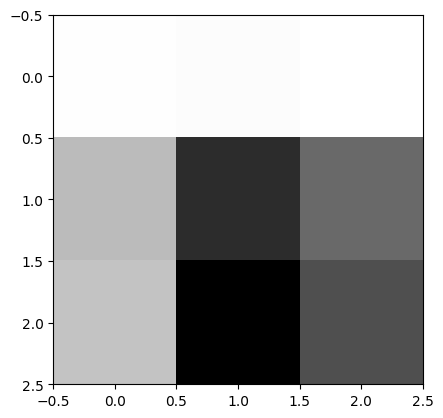

In [18]:
print("Kernel:")
print(kernel)
print()
print("Shape: ", kernel.shape)
print()
plt.imshow(kernel, cmap='gray');

We can also look at the first 8 filters from first convolutional layer. Each row is a different channel.

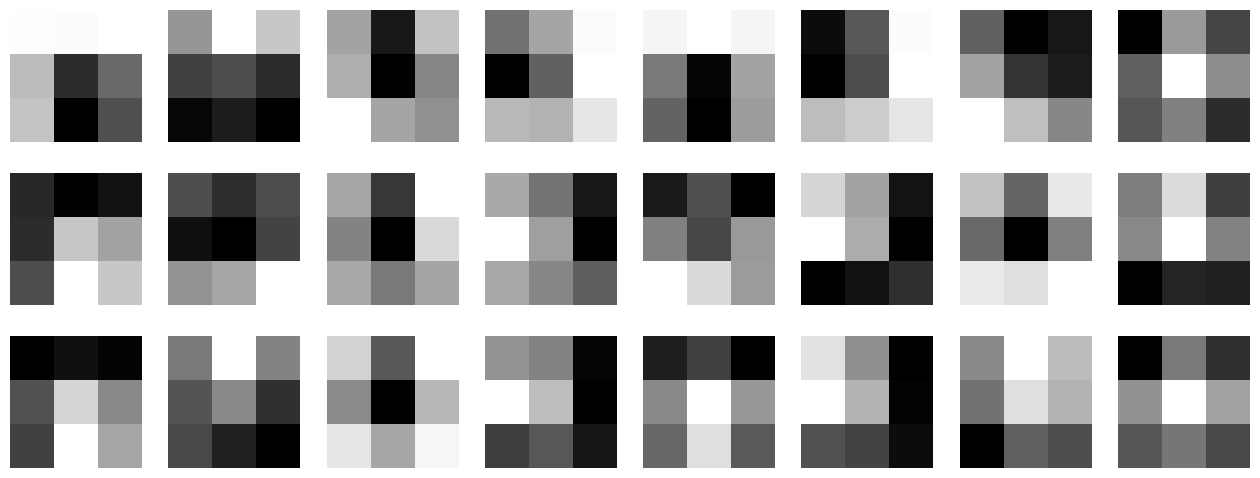

In [19]:
fig, axs = plt.subplots(ncols=8, nrows=3, figsize=(16, 6), sharex=True, sharey=True)

for ch in range(3):
  for k in range(8):
    kernel = extract_kernel(model, K=k, CH=ch)
    axs[ch, k].imshow(kernel, cmap='gray')
    axs[ch, k].axis('off')

plt.show()

### 4.1.1. Visualize feature maps

The activation maps, called feature maps, capture the result of applying the filters to input, such as the input image or another feature map.

The idea of visualizing a feature map for a specific input image would be to understand what features of the input are detected or preserved in the feature maps. The expectation would be that the feature maps close to the input detect small or fine-grained detail, whereas feature maps close to the output of the model capture more general features.

Here, we will produce our feature maps. We will use a following function to perform a convolution operation.

In [20]:
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

We call convolution function with and input image and the kernel. Since the kernel is for the third channel, we also use just the third channel of an image. To recap, image array has a shape `(1, 299, 299, 3)`. We don't need the batch dimension and we will take only the third channel, so we can use `img_array[0, :, :, 2]`.

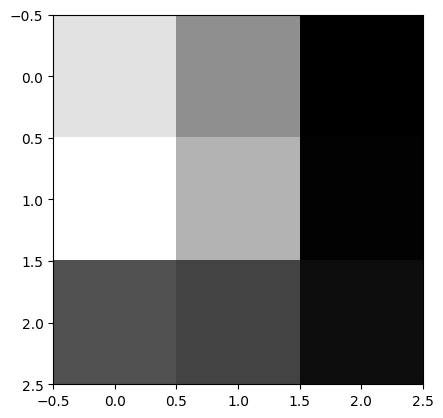

In [21]:
# Convolve with the image
kernel = extract_kernel(model, CH=2, K=5)
plt.imshow(kernel, cmap='gray');
out = convolve2D(img_array[0, :, :, 2], kernel)

Here is just a helper function to plot two images side by side.

In [22]:
def plot_comparison(img_original, img_filtered, img_title_filtered, gray=True):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 8), sharex=True, sharey=True)

    if gray:
      ax1.imshow(img_original, cmap='gray')
    else:
      ax1.imshow(img_original)
    ax1.set_title('Original')
    ax1.axis('off')
    if gray:
      ax2.imshow(img_filtered, cmap='gray')
    else:
      ax2.imshow(img_filtered)
    ax2.set_title(img_title_filtered)
    ax2.axis('off')

In the feature map, we can see what parts of an input image are kept and highligted. Can you describe what are those features?

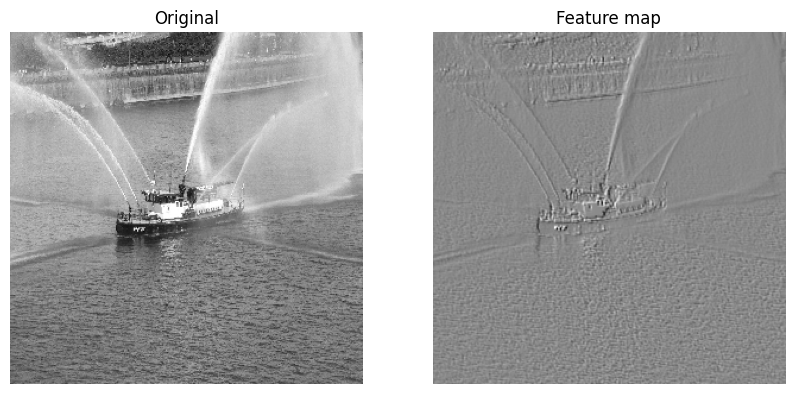

In [23]:
plot_comparison(img_array[0, :, :, 2], out, 'Feature map', gray=True)

We can also visualize feature maps produced by the 24 filters visualized few cells above.

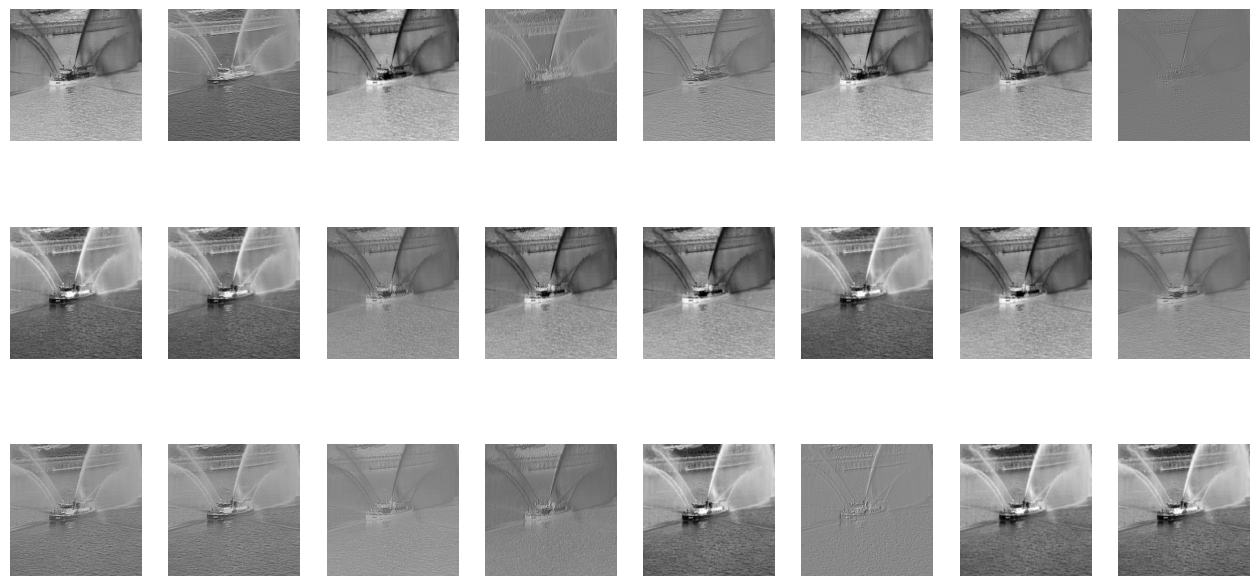

In [24]:
fig, axs = plt.subplots(ncols=8, nrows=3, figsize=(16, 8), sharex=True, sharey=True)

for ch in range(3):
  for k in range(8):
    kernel = extract_kernel(model, K=k, CH=ch)
    out = convolve2D(img_array[0, :, :, ch], kernel)
    axs[ch, k].imshow(out, cmap='gray')
    axs[ch, k].axis('off')

plt.show()

### Excercise 2: Design kernel

In [25]:
## define custom 3x3 kernel array

## plot the kernel

## convolve the image with your kernel

## plot the result

## 4.2. Guided Backpropagation

Guided backpropagation is a modified version of backpropagation, which is a technique used to train deep learning models. This allows us to determine which input features are responsible for a particular output value.

For further explanation and Pytorch implementation, look at this [article](https://leslietj.github.io/2020/07/22/Deep-Learning-Guided-BackPropagation/).

In [26]:
@tf.custom_gradient
def guided_relu(x):
    # guided version of relu which lets back only postive gradients in backpropogation
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

    return tf.nn.relu(x), grad

class GuidedBackprop:
    def __init__(self, model):
        self.model = model
        self.num_classes = model.output.shape[1]
        self.gb_model = self.build_guided_model()

    def __call__(self, image: np.ndarray, class_index: int):
        return self.guided_backprop(image, class_index)

    def build_guided_model(self):

        # build a guided version of the model replace ReLU with guided ReLU
        gb_model = tf.keras.Model(
            self.model.inputs, self.model.output
        )
        layers = [
            layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
        ]
        for layer in layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, image: np.ndarray, class_index: int):
        # convert to one hot representation to match our softmax activation in the model definition
        expected_output = tf.one_hot([class_index] * image.shape[0], self.num_classes)
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
            loss = tf.keras.losses.binary_crossentropy(
                expected_output, outputs
            )
        # get the gradient of the loss with respect to the input image
        grads = tape.gradient(loss, inputs)[0]
        return grads

To look at some other images as well, we will load flamingo image here.

1615143/1615143 [==============================] - 0s 0us/step


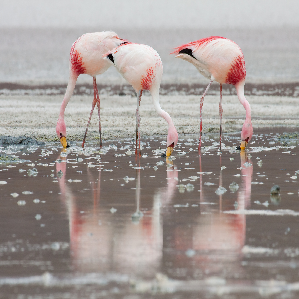

In [27]:
# `img_array` is for the input of neural network and `img` is for displaing
img_array, img = load_image(image_name="flamingo", size=img_size)

model = keras.applications.xception.Xception(
    input_shape=(img_size[0], img_size[1], 3)
)

img

In [28]:
preds = model(img_array).numpy()
decode_preds(preds)

flamingo (94.63%), id: 130
crane (0.63%), id: 134
spoonbill (0.49%), id: 129


We create an interpretation object with our model as a parameter. Then we can just call it with the input image and index of a class we are interested it.

In [30]:
guidedBackprop = GuidedBackprop(model)
saliency_map = guidedBackprop(img_array, class_index=130).numpy()

We need to do one more thing before visualization - we need to normalize values of output map.

In [31]:
def normalize(image):
    norm = (image - image.mean())/image.std()
    norm = norm * 0.1
    norm = norm + 0.5
    norm = norm.clip(0, 1)
    return norm

saliency_map = normalize(saliency_map)

And now we can plot the Guided Backpropagation output. It is a subset of an original image. It might not looks like it at a first look, but keep in mind that substraction is being done on each channel. So for example, in the water and sky area, mostly the blue channel is important.

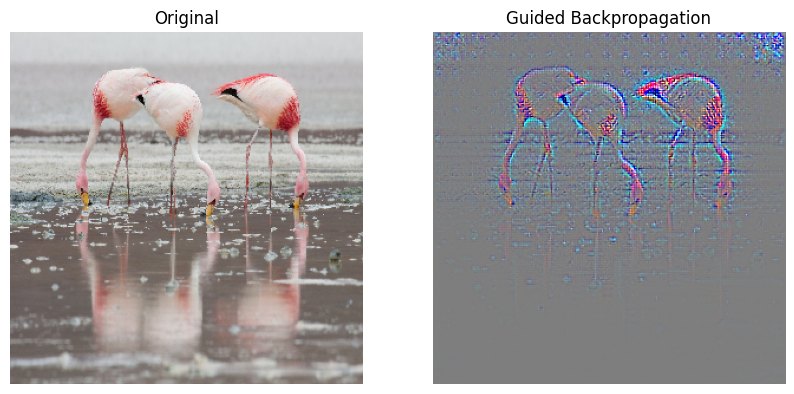

In [32]:
plot_comparison(img, saliency_map, 'Guided Backpropagation', gray=False)

## 4.3. Grad-CAM

We will move to the second section of interpretation methods now. These methods are working with the whole model and they try to highlight parts of the input image that were important for the model's decision. Meaning, what parts of a given image make it, let's say, a cat image.

Gradient-weighted Class Activation Mapping (Grad-CAM) produces a coarse localization map highlighting the important regions in the image for predicting the concept. For deeper understanding and more examples, follow this [article](https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353).

Here, the implementation of Grad-CAM method based on the [keras example](https://keras.io/examples/vision/grad_cam/) is provided.

In [33]:
class GradCam():
    def __init__(self, model):
        self.model = model

    def __call__(self, input, pred_index=None, last_conv_layer_name=None):
        if last_conv_layer_name == 'all':
            return self._make_all_layer_gradcam(input, pred_index)

        if last_conv_layer_name is None:
            last_conv_layer_name = self._get_last_conv_layer_name()

        return self._make_gradcam(input, pred_index, last_conv_layer_name)

    def _make_gradcam(self, input, pred_index, last_conv_layer_name):
        # First, we create a model that maps the input image to the activations
        # of the last conv layer as well as the output predictions
        grad_model = tf.keras.models.Model(
            [self.model.inputs], [self.model.get_layer(last_conv_layer_name).output, self.model.output]
        )

        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(input)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the output class
        # then sum all the channels to obtain the heatmap class activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

    def _make_all_layer_gradcam(self, input, pred_index):
        layers = [layer.name for layer in reversed(self.model.layers) if len(layer.output_shape) == 4 and (isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, keras.src.layers.convolutional.separable_conv2d.SeparableConv2D))]
        #layers = [layer.name for layer in reversed(self.model.layers) if len(layer.output_shape) == 4]
        cams = []
        for layer in layers:
            cam = self._make_gradcam(input, pred_index, layer)
            cam = cv2.resize(cam, (input.shape[2], input.shape[1]))
            cams.append(cam)
        return np.mean(cams, axis=0)

    def _get_last_conv_layer_name(self):
        layers = [layer.name for layer in reversed(self.model.layers) if len(layer.output_shape) == 4 and (isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, keras.src.layers.convolutional.separable_conv2d.SeparableConv2D))]
        return layers[0]

Again, we are going to load the fireboat image and the model.

In [34]:
# `img_array` is for the input of neural network and `img` is for displaing
img_array, img = load_image(image_name="fireboat", size=img_size)

model = keras.applications.xception.Xception(
    input_shape=(img_size[0], img_size[1], 3)
)

To interpret the images, we need to create an object of `GradCam` first with our model as a parameter.

In [35]:
gradcam = GradCam(model)

After this, we can just call the `gradcam` object with the input image as a parameter. The input image needs to preprocessed in the same way as for our neural netwoek model. The second parameter is the name of the last convolutional layer. The interpretation is computed on this layer. The intuition is that the last convolutional layer should work with the high-level concepts representing the class.

In [36]:
map = gradcam(img_array, last_conv_layer_name = "block14_sepconv2_act")

When we vidualize the result we can see that this blob part of an input was marked as important.

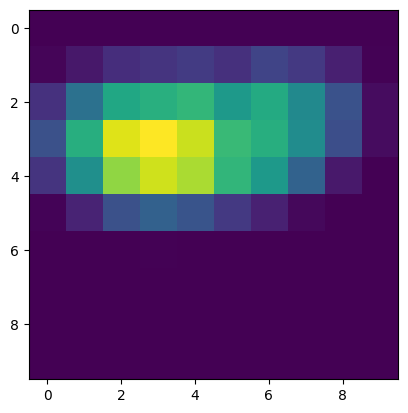

In [37]:
plt.imshow(map)

If you look at the axis, the size of the output map is 10x10, but our image is 299x299. We will resize the output map to mach the size of an input image.

In [38]:
# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (img_array.shape[2], img_array.shape[1])
heatmap = cv2.resize(map, (w, h))

And we can visualize output map next to an image. We can see that the part of an image with a boat and a water jets is important.

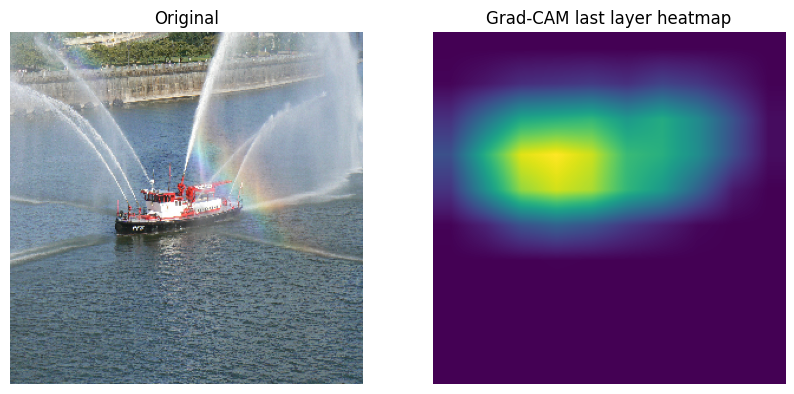

In [39]:
plot_comparison(img, heatmap, 'Grad-CAM last layer heatmap', gray=False)

Another option of this GradCam implemetation is to set `last_conv_layer_name="all"` which will average information from all convolutional layers in the neural network, not just the last one.

In [40]:
map_all = gradcam(img_array, last_conv_layer_name="all")

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (img_array.shape[2], img_array.shape[1])
heatmap_all = cv2.resize(map_all, (w, h))

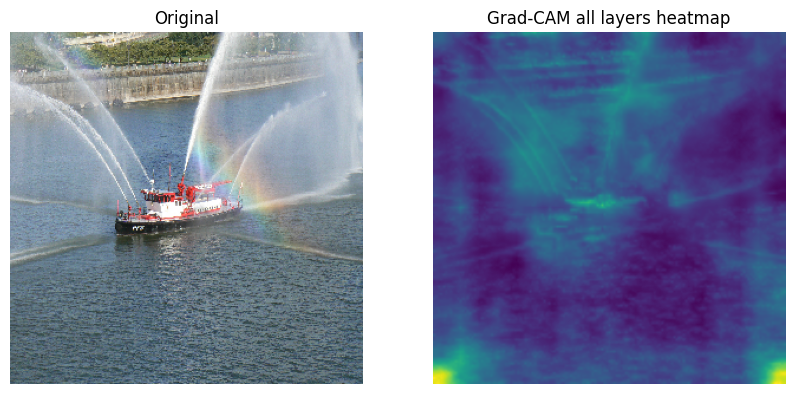

In [41]:
plot_comparison(img, heatmap_all, 'Grad-CAM all layers heatmap', gray=False)

### Excercise 3: Image and heatmap on top of eachother

It could be better to plot the heatmap on top of the image to ideantify exact places in the image that were important for the model.

In [ ]:
## plot the heatmap on top of the image
## make the image grayscale for better visualization
## make the heatmap transparent to see the image trough it

### 4.3.1. Prediction index parameter

There is a one more parameter of this Grad-CAM implementation that we haven't talked about - `pred_index`. When the Grad-CAM is computing the interpretation, it is computing it towards the selected class - a fireboat in the examples above. But the network have some information about other classes as well.


For this part, we will use a diferent image. We will load and image with both cat and dog in it.

72452/72452 [==============================] - 0s 2us/step


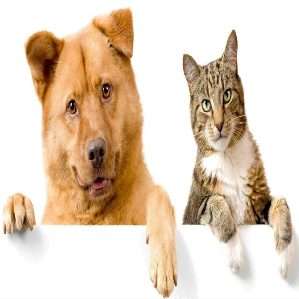

In [42]:
# `img_array` is for the input of neural network and `img` is for displaing
img_array, img = load_image(image_name="cat_and_dog", size=img_size)
img

Since the model was trained to classify images with only one object in it, we can see that it is not sure about predictions for this image. But we can also see that a cat and a dog made it into a top three predictions.

In [43]:
preds = model(img_array).numpy()
decode_preds(preds)

chow (6.34%), id: 260
Egyptian_cat (5.04%), id: 285
tiger_cat (4.74%), id: 282


This is the part where we can use the `id` of a class and pass it as a `pred_index` parameter of a Grad-CAM. Index for a chow is `260` and in the Grad-CAM heatmap, we can see that the model was focusing on the dog part of an image to make this prediction.

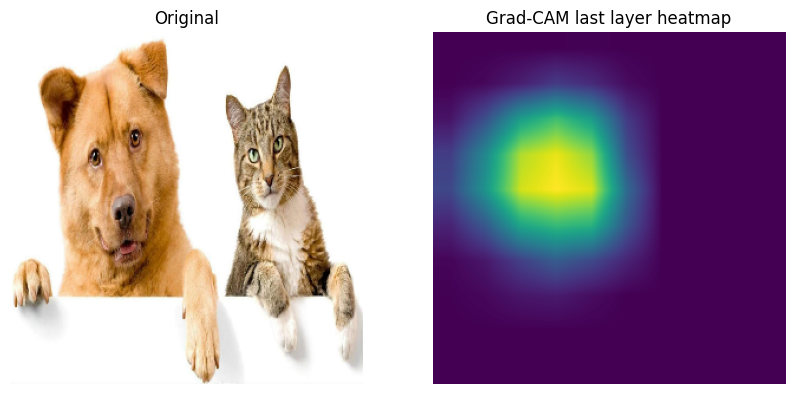

In [44]:
map = gradcam(img_array, last_conv_layer_name = "block14_sepconv2_act", pred_index=260)
(w, h) = (img_array.shape[2], img_array.shape[1])
heatmap = cv2.resize(map, (w, h))
plot_comparison(img, heatmap, 'Grad-CAM last layer heatmap', gray=False)

When we put the index for Egyptian cat (285), the cat part of an image gets highlighted.

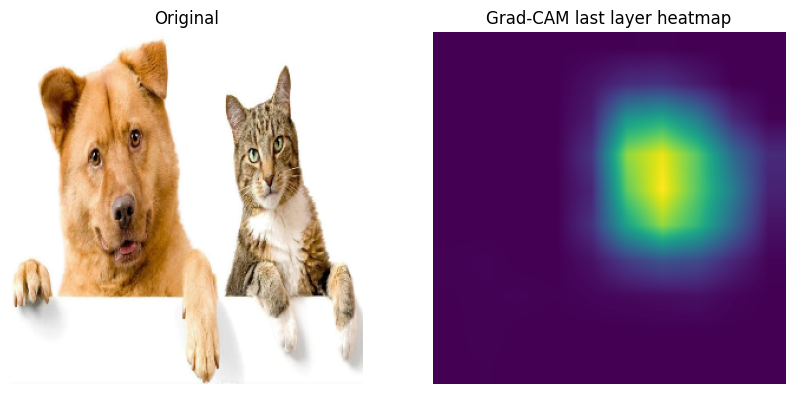

In [45]:
map = gradcam(img_array, last_conv_layer_name = "block14_sepconv2_act", pred_index=285)
(w, h) = (img_array.shape[2], img_array.shape[1])
heatmap = cv2.resize(map, (w, h))
plot_comparison(img, heatmap, 'Grad-CAM last layer heatmap', gray=False)

## 4.4. Integrated Gradients

The last interpretation technique we will experiment with in this notebok is Integrated Gradients. It is an another way extract important parts of an input image.

To identify these parts, we need to choose a baseline input. A baseline input can be a black image (all pixel values set to zero), white image, or random noise for example. The shape of the baseline input needs to be the same as our input image, e.g. (299, 299, 3).

To read in-depth about integrated gradients and why this method works, consider reading this excellent [article](https://distill.pub/2020/attribution-baselines/).

In [51]:
# implementation based on https://keras.io/examples/vision/integrated_gradients/

def get_gradients(model, img_input, pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[:, pred_idx]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(model, img_input, pred_idx=None, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a label.

    Args:
        img_input (ndarray): Original image
        pred_idx: Label to compute integrated gradients for
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # 2. Preprocess the interpolated images
    interpolated_image = keras.applications.xception.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(model, img, pred_idx=pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


def random_baseline_integrated_gradients(
    model, img_input, pred_idx, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(img_input.shape) * 255
        igrads = get_integrated_gradients(
            model=model,
            img_input=img_input,
            pred_idx=pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)


    integrated_grads = tf.convert_to_tensor(integrated_grads)
    # average over random samples
    integrated_grads = tf.reduce_mean(integrated_grads, axis=0)
    # average over channels
    integrated_grads = tf.reduce_sum(tf.math.abs(igrads), axis=-1)
    # 3. Return the average integrated gradients for the image
    return integrated_grads

Once again, we are going to load an image and the model. For the image, we are doing a little bit different handling that is needed for this implementation of Integrated Gradients.

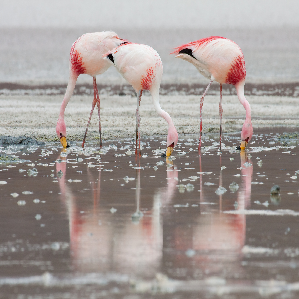

In [47]:
# `img_array` is for the input of neural network and `img` is for displaing
img_array, img = load_image(image_name="flamingo", size=img_size)
array = keras.utils.img_to_array(img)
orig_img = np.copy(array).astype(np.uint8)

model = keras.applications.xception.Xception(
    input_shape=(img_size[0], img_size[1], 3)
)

img

In [48]:
preds = model.predict(img_array)
decode_preds(preds)

1/1 [==============================] - 2s 2s/step
flamingo (94.63%), id: 130
crane (0.63%), id: 134
spoonbill (0.49%), id: 129


We will use Integrated Gradients with a random baseline. Below is a simple visualization what it means.

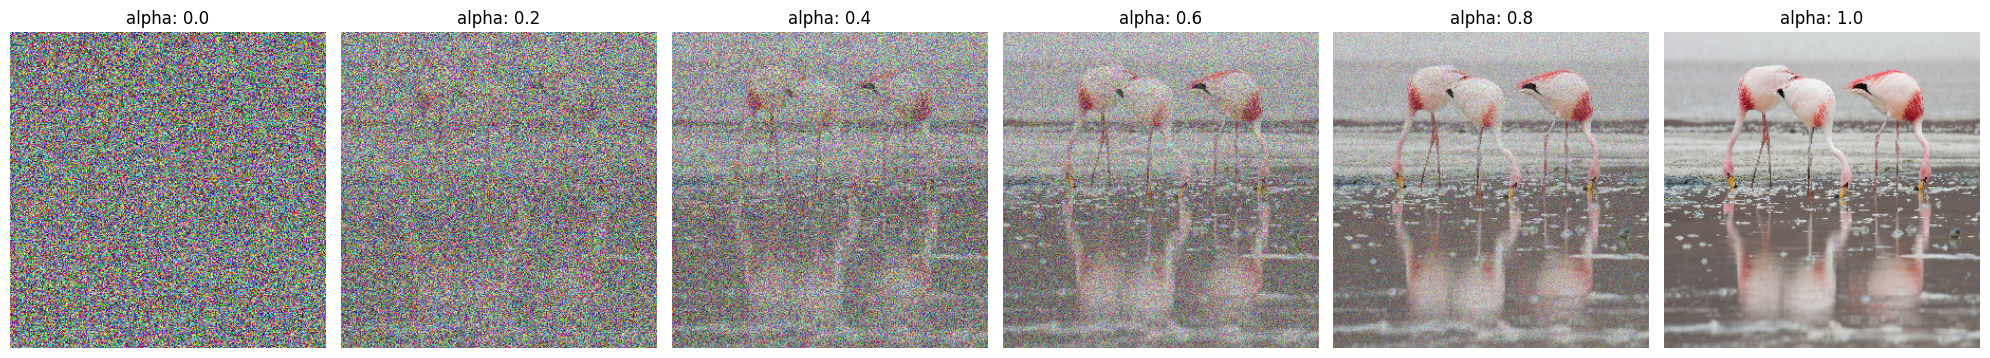

In [49]:
#@title Interpolate images

def interpolate_images(baseline,
                       image,
                       alphas):
  image /= 2
  image += 0.5

  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

baseline = tf.cast(np.random.random(orig_img.shape), tf.float32)
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
img_input = img_array.astype(np.float32)

interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_input[0, :, :, :],
    alphas=alphas)

fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

In [52]:
# Get the integrated gradients
igrads = random_baseline_integrated_gradients(
    model, np.copy(orig_img), pred_idx=130, num_steps=50, num_runs=2
)

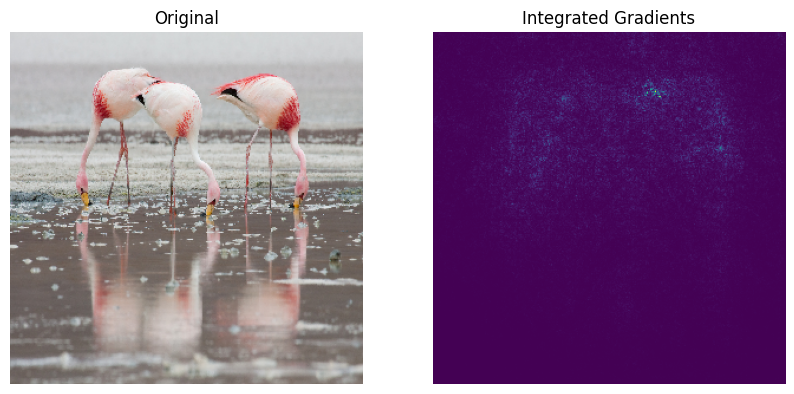

In [53]:
plot_comparison(orig_img, igrads, 'Integrated Gradients', gray=False)

In [54]:
# Taking a matrix of size 5 as the kernel
kernel = np.ones((5, 5), np.uint8)
dilated_igrads = cv2.dilate(igrads.numpy(), kernel=kernel)

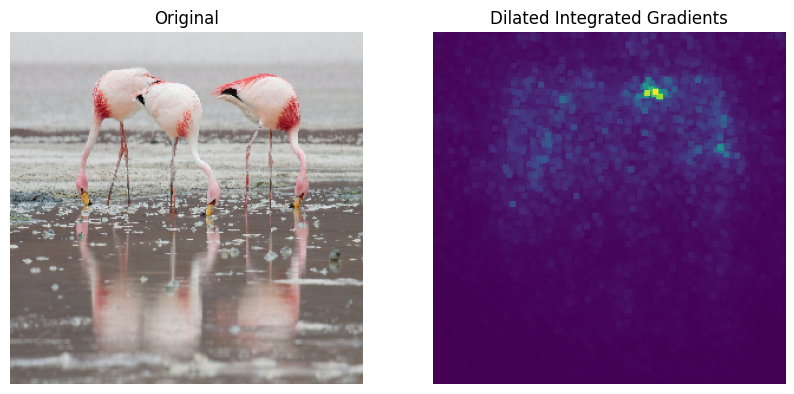

In [55]:
plot_comparison(orig_img, dilated_igrads, 'Dilated Integrated Gradients', gray=False)

## Excercise 4: Experiment with baselines

In the example above, we have used `random_baseline_integrated_gradients()` where the baseline was randomly generated noise. You can try different baselines, for example:
- white image
- black image
- random noise with a different distribution
- blurred input image
- different input image